<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/08_pytorch_replicando_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torchvision
import os

NUM_WORKERS= os.cpu_count()

#### 0. Codigos com importacoes e download de dados de sempre

In [49]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Conseguindo dados

Os mesmos dados pizza, steak, sushi.

Baixado com a funcao `donwload_data()` criada no modulo anterior

In [51]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [52]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. TRansformandos em DataLoaders

### 2.1 Transforms

In [53]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Transforms criado manualmente: {manual_transforms}")

Transforms criado manualmente: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


### 2.2 Criando os dataloaders

In [54]:
BATCH_SIZE = 32 #O paper usa 4096 de batch_size, mas pode ser muito grande para o hardware disponivel. Comecer pequeno

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE,
                                                                               num_workers=NUM_WORKERS)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ff45c272fb0>,
 ['pizza', 'steak', 'sushi'])

### 2.3 Visualizando uma Imagem

In [55]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[5], label_batch[5]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

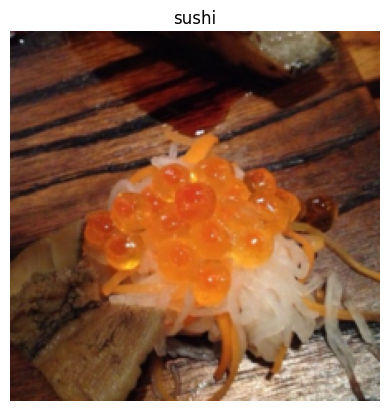

In [56]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replicando ViT: Overview

Olhar para todo um paper de uma pesquisa de machine learn porde ser intimdidador, por isso e para tornar mais entendivel iremos quebrar em pequenas pecas:

* **Inputs** - O que entra no modelo? (Em nosso caso, imagens tensor)
* **Outputs** - O que sai do modelo/layer/block? (Em nosso caso, queremos que o modelo gere uma label de classificacao para imagens)
* **Blocks** - Uma colecao de layers
* **Model** - Uma colecao de blocks

### 3.1 ViT overview: Pecas do quebra cabeca:

* Figura 1: Visao geral do arquitetura
* Quatro equacoes: Equacoes matematicas que definem as funcoes de cada layer/bloco
* Table 1/3: Diferentes hyoerparametros para arquiteura/treinamento

### Figura 1:

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/08-vit-paper-figure-1-architecture-overview.png)

* Embedding = Learnable representation(Comeca com valores aleatorios e melhorar atraves do tempo)

### Quatro Equacoes

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)



### Tabela 1:

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large e ViT-huge sao os diferentes tamanhado para os mesmo modelo de arquitetura da ViT.
* Layers - O numero de camadas de *Transformer encoder*
* Hidden size $D$ - O tamanho do *embedding* ao longo da arquitetura
* MLP size - O numero de hidden untis/neuronios na MLP (Perpecton multi-camadas)
* Head - O numero de *Multi head self-attention*

## 4. Equacao 1: Dividindo os dados em patches e criar embeddings de classe, posição e patches

Layers = entrada -> operecao -> saida

QUal e o formato da entrada?

Qual e o formato da saida?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape:

* Input image: $H\times{W}\times{C}$ (altura x largura x cores)
* Output image: ${N \times\left(P^{2} \cdot C\right)}$
* H = Altura
* W = Largura
* C = Canais de cor
* P = tamanho dos paeches = (altura x largura) / P^2
* D = Tamanho constante do vetor latente = dimensão do embedding


In [57]:
#CRIando exemplos
height = 224
width = 224
color_channels = 3
patch_size = 16

#Claculando o numero de patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches


196

In [58]:
#Shape de entrada
embedding_layer_input_shape = (height, width, color_channels)

#Shape da saida
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Entrada (Uma imagem 2d): {embedding_layer_input_shape}")
print(f"Saida (Sequencia simples de pacthes): {embedding_layer_output_shape}")



Entrada (Uma imagem 2d): (224, 224, 3)
Saida (Sequencia simples de pacthes): (196, 768)


### 4.2 Transformando uma imagem em patches

Hay que visualizar

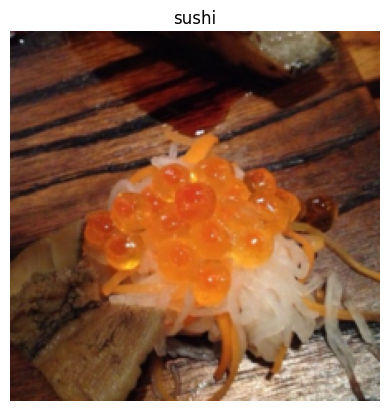

In [59]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [60]:
image.shape

torch.Size([3, 224, 224])

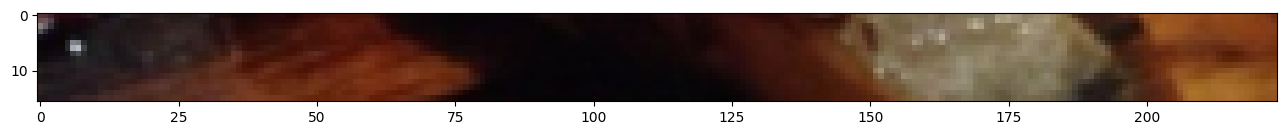

In [61]:
image_permuted = image.permute(1, 2, 0)

#Pegando apenas a linha de cima, por linha digo os preimso 16px da altura
patch_size=16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :]);

Numero de patchs por linha: 14.0
Patch size: 16 pixels x 16 pixels


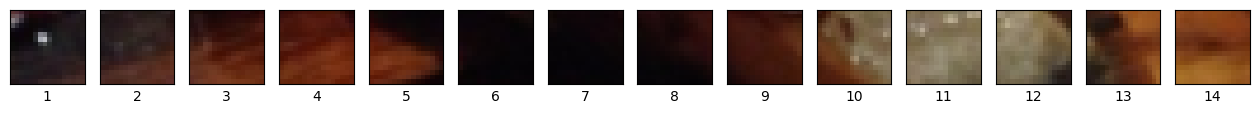

In [62]:
#Cinfigurando para plotar a linha de cima como patches
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "patch_size tem que ser divisivel por patch_size"
print(f"Numero de patchs por linha: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

#Criuando os subplots necessarios
fig, axs = plt.subplots(nrows=1,
                       ncols=img_size // patch_size, #Uma coluna para cada patch
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))

#Iterando sobre o numero de patches na primeira linha
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
  axs[i].set_xlabel(i+1) #Configurando a label do patch
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Numero de patches por linha: 14.0  
Numero de patches por coluna: 14.0  
Total patches: 196.0  
Tamanho do Patch: 16 pixels X 16 pixels


Text(0.5, 0.98, 'sushi -> Patchified')

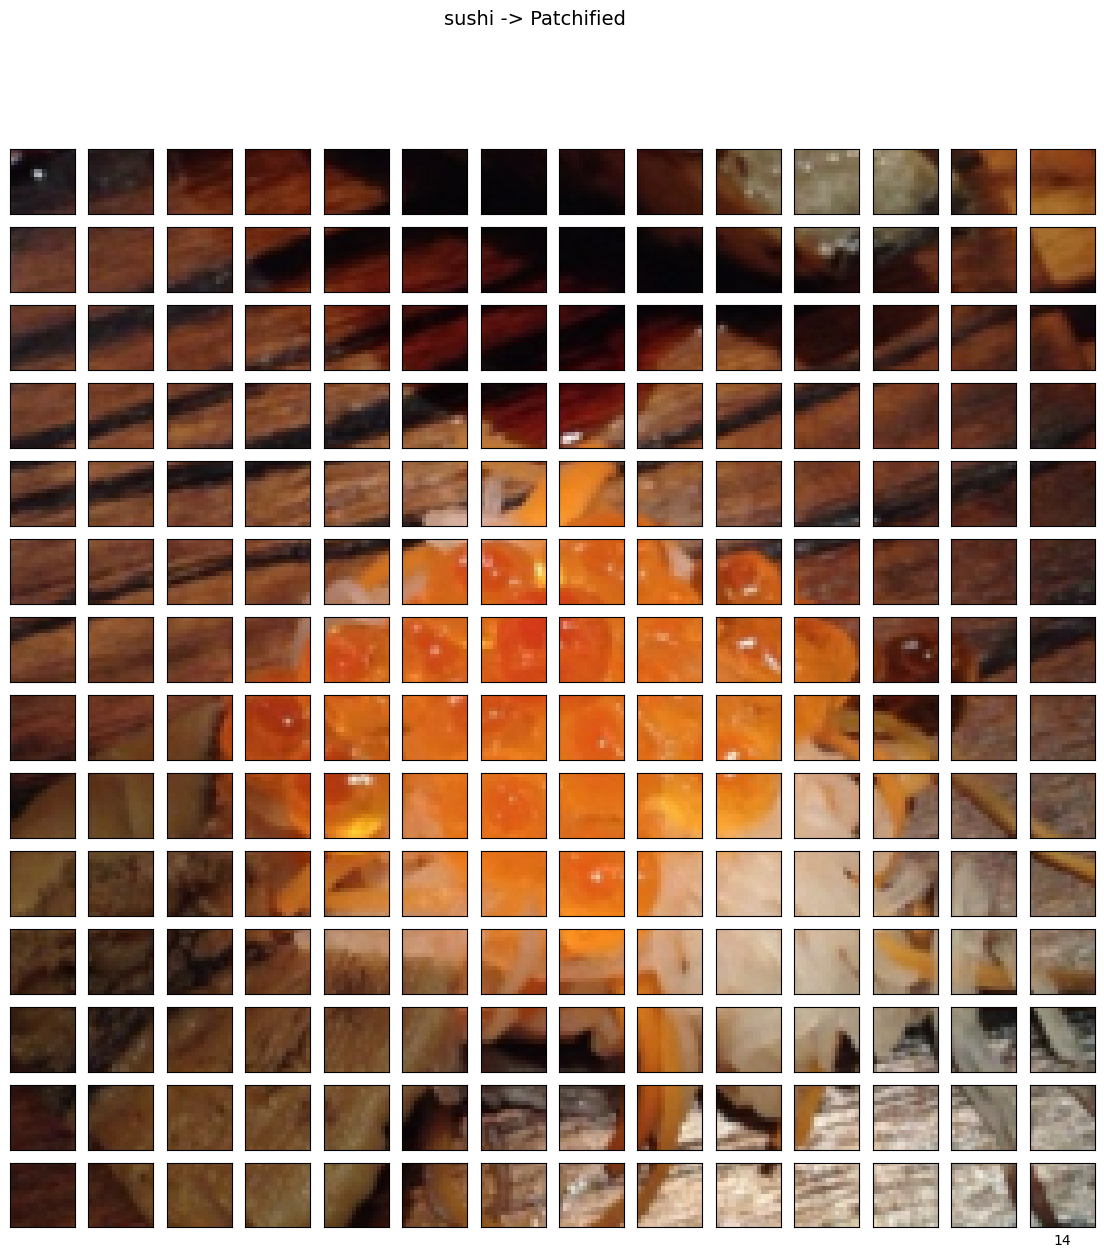

In [63]:
#Configurando o codigo para plotar a imagem toda
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "patch_size tem que ser divisivel por patch_size"
print(f"Numero de patches por linha: {num_patches}\
  \nNumero de patches por coluna: {num_patches}\
  \nTotal patches: {num_patches*num_patches}\
  \nTamanho do Patch: {patch_size} pixels X {patch_size} pixels")

#Criando os pubplots
fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

#Percorrendo altura x lagura da imagem
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    #Plotando aimagem permutada em axes dieferentes
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #Itera sobre a altura
                                    patch_width:patch_width+patch_size, #Itera sobre a largura
                                    :]) #PEga todos os canais de cores

  axs[i, j].set_ylabel(i+1,
                       rotation="horizontal",
                       horizontalalignment='right',
                       verticalalignment='center')
  axs[i, j].set_xlabel(j+1)
  axs[i, j].set_xticks([])
  axs[i, j].set_yticks([])
  axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)

### 4.3 Criando patches da imagem e trasnformando em embedding pathes

Podemos criar patches de imagens e patchs embedding em um unico passo usando `torch.nn.Conv2d()` e setando o kernel size e stride para o tamanho de `patch_size`.

In [64]:
#CRiando uma camada conv2d para trasnformar patches de imagens em mapas de características aprendíveis (embeddings)
from torch import nn

#COnfigurando o ptch size
patch_size=16

#Criando a camada conv2d com os hyperparametros do ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768, #D size
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

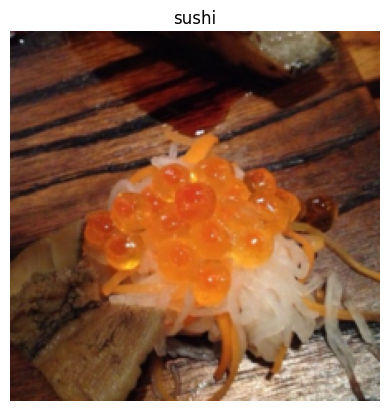

In [65]:
#Visualizando imagem
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [66]:
#PAssando a imagem pela camada convulocional
image_out_of_conv = conv2d(image.unsqueeze(0)) #Adicionando a camada batch -> (batch, color, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Apos passar um imagem pela camada `conv2d`, seu shape eh:



```python
torch.Size([1, 768, 14, 14]) #[batch_size, embedding_dim, feature_map_height, feature_map_width]
```



Mostrando mapas de caracteristicas da conv aleatorios por index: [672, 29, 418, 74, 379]


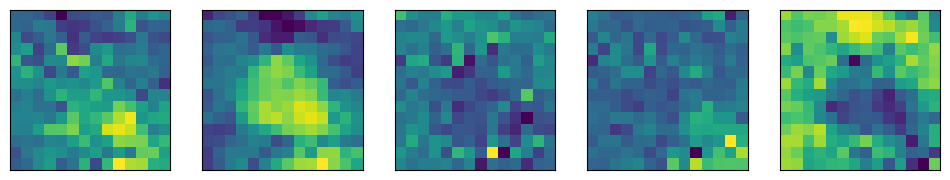

In [67]:
#PLotando convulutional feature maps randomicos(embedding)
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f"Mostrando mapas de caracteristicas da conv aleatorios por index: {random_indexes}")

#CRiando o plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

#Plotando mapas de caracteristicas aleatorios
for i, idx, in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]#Index da saida
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [68]:
#Pegando um mapa de caracteriticas no formato de tensor
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0353, -0.0934, -0.0574, -0.0982, -0.0968, -0.0295, -0.0411,
           -0.0524, -0.0790, -0.1693, -0.1995, -0.2946, -0.0339, -0.1691],
          [-0.0716, -0.1325, -0.1379, -0.1479, -0.0653, -0.0425, -0.0284,
           -0.0348, -0.0371, -0.0516, -0.1820, -0.1272, -0.0794, -0.2416],
          [-0.1723, -0.1293, -0.0729, -0.0612, -0.2167, -0.0537, -0.0693,
           -0.0730, -0.1027, -0.1019, -0.0427, -0.0212, -0.1252, -0.1348],
          [-0.0841, -0.2413, -0.1419, -0.0352, -0.1509, -0.1803,  0.0150,
           -0.1461, -0.0577, -0.2470, -0.0404, -0.1487, -0.1243, -0.0568],
          [-0.1442, -0.1857, -0.0777, -0.0409, -0.2161, -0.3246, -0.3193,
           -0.2761, -0.1637, -0.2081, -0.1419, -0.1647, -0.1359, -0.0735],
          [-0.1621, -0.1472, -0.2169, -0.0669, -0.1444, -0.1205, -0.2069,
           -0.2332, -0.2024, -0.2363, -0.0927, -0.1244, -0.1533, -0.1252],
          [-0.0941, -0.1850, -0.1926, -0.1095, -0.2526, -0.2167, -0.2721,
           -0.2311, -0.2420, -0.

### 4.4 Flatteing the patch embedding with `torch.nn.Flatte()`

Neste momento, temos uma série de mapas de características convolucionais (embeddings de patches) que queremos achatar em uma sequência de embeddings de patches para atender aos critérios de entrada do codificador do Transformer ViT.

In [69]:
#242 segunda do dia, falta os codigos
print(f"{image_out_of_conv.shape} -> (batch_size, embedding_dim, feature_map_height, feature_map_width)")


torch.Size([1, 768, 14, 14]) -> (batch_size, embedding_dim, feature_map_height, feature_map_width)


Obejetivo: (batch_size, number_of_patches, embedding_dim)

In [70]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Shape da imagem original: torch.Size([3, 224, 224])
Shape do mapa de caracteristicas (patches): torch.Size([1, 768, 14, 14])
Shape do mapa de caracteristicas apos a camada flatten: torch.Size([1, 768, 196])


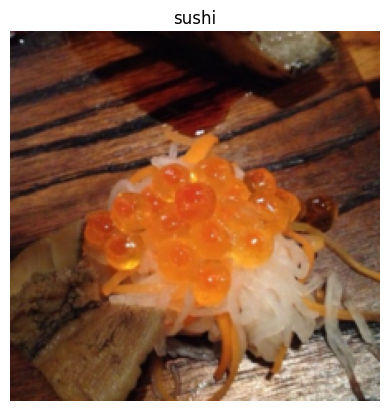

In [71]:
#TUdo jmunto
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)
print(f"Shape da imagem original: {image.shape}")

#Transformando a imagem em mapa de caracteristicas
image_out_of_conv = conv2d(image.unsqueeze(0)) #Add a dimensao batch
print(f"Shape do mapa de caracteristicas (patches): {image_out_of_conv.shape}")

#Flatten(achatando doi verbo achatar)
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Shape do mapa de caracteristicas apos a camada flatten: {image_out_of_conv_flattened.shape}")


In [72]:
#Reorganizando a saida da camada flatten
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 1, 2)
print(f"{image_out_of_conv_flattened.permute(1, 2, 0).shape} -> (batch_size, number_of_patches, embedding_dimension)")

torch.Size([768, 196, 1]) -> (batch_size, number_of_patches, embedding_dimension)


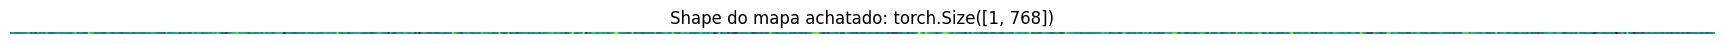

In [73]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
#single_flattened_feature_map

#plotando o mapa de caracteristica achatado(Visualmente)
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Shape do mapa achatado: {single_flattened_feature_map.shape}")
plt.axis(False);

### 4.5 Transformando o ViT path embedding layer em um modulo Pytorch

Para isso, se necessita:

1. Criar uma classe chaada `PathEmbedding` que herda de `nn.Module`.
2. Inicializar com os hyperparametros apropriados, sendo eles channels, embedding dim, path size.
3. Criar uma camada para trasnformar a imagem em embedding pathes, usando nn.Conv2d().
4. Criar uma camda flatten, para achatar o mapoa de caracteristicas que saira da camda do passo 3.
5. Definir um metodo forward() para fazer a computacao
6. Garantir que o shape da saida da camada reflete no que e requisitado output desejado da patch embedding.

In [74]:
# 1. Criando a classe
class PatchEmbedding(nn.Module):
  # 2. Inicializando a camada com os hyperparametros
  def __init__(self,
              in_channels:int=3,
              patch_size:int=16,
              embedding_dim:int=768):
    super().__init__()

    self.patch_size = patch_size

    #3. riando a camda que transforma a imagem em embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  # 5. Definicao do meto forward
  def forward(self, x):
    #Criando "assert" para garantir os inputs corretos
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Imagem de entrada deve ser divisivel pelo patch_size, shape da imagem: {image_resolution}, patch size: {self.patch_size}"

    #REalizando o forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. fazendo a sequencia de embedding esatr na ordem necessaria (batch_size, number_og_patches, embedding_dim)
    return x_flattened.permute(0, 2, 1)


In [75]:
set_seeds()

#Craindoa instacia da camada de embedding
patchify = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

#Passsando uma imagem pela camada
print(f"Formato da imagem de entrada: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Formato da saida da sequencia de embedding : {patch_embedded_image.shape}")


Formato da imagem de entrada: torch.Size([1, 3, 224, 224])
Formato da saida da sequencia de embedding : torch.Size([1, 196, 768])


In [76]:
rand_image_tensor = torch.randn(1, 3,224, 224)
rand_image_tensor_bad = torch.randn(1, 3,250, 250)

#patchify(rand_image_tensor_bad)

### 4.6 Criando o token das classes

Objetivo: COlocar o token da classe no inicio do patch embedding

In [77]:
patch_embedded_image

tensor([[[-0.0965, -0.0287, -0.0360,  ...,  0.0832, -0.0593,  0.0193],
         [-0.2393, -0.0175, -0.0327,  ...,  0.2027, -0.1115,  0.0594],
         [-0.2117, -0.0282, -0.0453,  ...,  0.1231, -0.0929,  0.1690],
         ...,
         [-0.6541,  0.1407, -0.2657,  ...,  0.6207, -0.3441,  0.3142],
         [-0.7300,  0.0304, -0.2050,  ...,  0.5517, -0.2748,  0.1775],
         [-0.6428,  0.2502, -0.0697,  ...,  0.4909, -0.3111,  0.1074]]],
       grad_fn=<PermuteBackward0>)

In [78]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [79]:
#Cria um token de classa como um parametro aprendivel que compartilha o mesmo tamanho da embeddiing dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [80]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [81]:
#Adicionada o token de classe na frente do patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)
print(patch_embedded_image_with_class_embedding)
print(f"{patch_embedded_image_with_class_embedding.shape} -> batch_size, class_token + number_of_patches, embedding_dim")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0965, -0.0287, -0.0360,  ...,  0.0832, -0.0593,  0.0193],
         [-0.2393, -0.0175, -0.0327,  ...,  0.2027, -0.1115,  0.0594],
         ...,
         [-0.6541,  0.1407, -0.2657,  ...,  0.6207, -0.3441,  0.3142],
         [-0.7300,  0.0304, -0.2050,  ...,  0.5517, -0.2748,  0.1775],
         [-0.6428,  0.2502, -0.0697,  ...,  0.4909, -0.3111,  0.1074]]],
       grad_fn=<CatBackward0>)
torch.Size([1, 197, 768]) -> batch_size, class_token + number_of_patches, embedding_dim


### 4.7 Criando o embedding de posicao

Objetivo: Criar uma serie de emdeddings de posicao 1D aprendiveis e adicionar eles a sequencia de patches embeddings

In [82]:
#Visualizando a sequencia de patch embedding com a class embedding no inicio
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.0965, -0.0287, -0.0360,  ...,  0.0832, -0.0593,  0.0193],
          [-0.2393, -0.0175, -0.0327,  ...,  0.2027, -0.1115,  0.0594],
          ...,
          [-0.6541,  0.1407, -0.2657,  ...,  0.6207, -0.3441,  0.3142],
          [-0.7300,  0.0304, -0.2050,  ...,  0.5517, -0.2748,  0.1775],
          [-0.6428,  0.2502, -0.0697,  ...,  0.4909, -0.3111,  0.1074]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [83]:
#Calculando o N (numero de patches)
number_of_patches = int((height * width) / patch_size**2)

#Pegando a dimensao embedding
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

#Criando o embedding 1D aprendivel
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)

position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [84]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Shape do position embedding: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9035, 0.9713, 0.9640,  ..., 1.0832, 0.9407, 1.0193],
         [0.7607, 0.9825, 0.9673,  ..., 1.2027, 0.8885, 1.0594],
         ...,
         [0.3459, 1.1407, 0.7343,  ..., 1.6207, 0.6559, 1.3142],
         [0.2700, 1.0304, 0.7950,  ..., 1.5517, 0.7252, 1.1775],
         [0.3572, 1.2502, 0.9303,  ..., 1.4909, 0.6889, 1.1074]]],
       grad_fn=<AddBackward0>)
Shape do position embedding: torch.Size([1, 197, 768])


### 4.8 Colocando tudo junto: Da imagem ao embedding

Acima passo a passo, e celula a celula foi construido codigo para transformar uma imagem em uma sequencia de flattened patch embedding

Obejetivo de agora: FAzer tudo em uma unica celula

In [85]:
#Seed
set_seeds()

# 1. TAmanho do patch
patch_size = 16

# 2. MOstrando o shape original da imagem e pegando suas dimensoes
print(f"Shape da Imagem original: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Adicionanado a dimensao de batch na imagem
x = image.unsqueeze(0)
print(f"Shape da imagem de entrada: {x.shape}")

# 4. Criando a camda de patch embedding
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. PAssando a aimgem pela PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Shape da Patch Embedding: {patch_embedding.shape}")

# 6. Criando o token de classe
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) #Garantindo que seja "Aprendivel"
print(f"Shape do token de classes: {class_token.shape}")

# 7. Adicioando o token de classe a frente do patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Shape do patch embedding com o token de classes: {patch_embedding_class_token.shape}")

# 8. Criando o embedding de posicao
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# 9. Adicionando o embedding de posicao ao patch embedding com token de classes
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Shape do Patch e Posicao embedding: {patch_and_position_embedding.shape}")

Shape da Imagem original: torch.Size([3, 224, 224])
Shape da imagem de entrada: torch.Size([1, 3, 224, 224])
Shape da Patch Embedding: torch.Size([1, 196, 768])
Shape do token de classes: torch.Size([1, 1, 768])
Shape do patch embedding com o token de classes: torch.Size([1, 197, 768])
Shape do Patch e Posicao embedding: torch.Size([1, 197, 768])


## Equacao 2: Multihead Self-Attention (MSA Block)

Multihead self-attention: Para qual parte da sequencia se deve prestar mais atencao?
  * NEste caso, temos uma serie de embedded imagem patches, os quais se relacionam significativamente com os outros.
  * Desejamos que a ViT aprenda estar relacao/representacao

Para replicar MSA no pytorch: pytorch/torch.nn.MultiheadAttention
* LayerNorm = A normalização de camadas é uma técnica para normalizar as distribuições das camadas intermediárias. Isso permite gradientes mais suaves, treinamento mais rápido e melhor precisão de generalização.

  * Normalização = fazer com que tudo tenha a mesma média e o mesmo desvio padrão
  No pytorch = torch.nn.LayerNorm: Normaliza os valores ao longo da dimensão D, no nosso caso, a dimensão D é a dimensão do embedding
    * Quando normalizacamos ao longo a embedding dimension, e parecido com fazer todos os degraus de uma escadaria de tamanho igual.


In [86]:
class MultiHeadSelfAttention(nn.Module):
  """ Cria um bloco MSA
  """

  def __init__(self,
             embedding_dim:int=768, #Tamanho do D (Embedding dimension) da tabela 1
             num_heads:int=2,
             attn_dropout:int=0):
    super().__init__()
    #Criando a camada de normalizacao (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #CRiando a camada multihead attention
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                              num_heads=num_heads,
                                              dropout=attn_dropout,
                                              batch_first=True) # E o batch que vem primeiro? (batch, seq, feature) -> (batch, number_of_patches, embedding_dimension)

  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
    return attn_output

In [87]:
#Insanciando o bloco MSA
multihead_self_attention_block = MultiHeadSelfAttention(embedding_dim=768,
                                                        num_heads=12,
                                                        attn_dropout=0)

#PAssando a imagem ebedding com path e posicao pelo bloco MSA
patched_image_trought_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Shape de entrada no bloco MSA: {patch_and_position_embedding.shape}")
print(f"Shape de saida no bloco MSA: {patched_image_trought_msa_block.shape}")


Shape de entrada no bloco MSA: torch.Size([1, 197, 768])
Shape de saida no bloco MSA: torch.Size([1, 197, 768])


In [88]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.9035, 0.9713, 0.9640,  ..., 1.0832, 0.9407, 1.0193],
         [0.7607, 0.9825, 0.9673,  ..., 1.2027, 0.8885, 1.0594],
         ...,
         [0.3459, 1.1407, 0.7343,  ..., 1.6207, 0.6559, 1.3142],
         [0.2700, 1.0304, 0.7950,  ..., 1.5517, 0.7252, 1.1775],
         [0.3572, 1.2502, 0.9303,  ..., 1.4909, 0.6889, 1.1074]]],
       grad_fn=<AddBackward0>)

In [89]:
patched_image_trought_msa_block

tensor([[[-0.1871, -0.2604,  0.0746,  ..., -0.3979,  0.9039, -0.4554],
         [-0.1896, -0.2537,  0.0783,  ..., -0.3928,  0.9165, -0.4626],
         [-0.1832, -0.2578,  0.0796,  ..., -0.3923,  0.9222, -0.4693],
         ...,
         [-0.1813, -0.2549,  0.0801,  ..., -0.3938,  0.9222, -0.4690],
         [-0.1810, -0.2533,  0.0795,  ..., -0.3960,  0.9216, -0.4692],
         [-0.1824, -0.2560,  0.0770,  ..., -0.3962,  0.9204, -0.4664]]],
       grad_fn=<TransposeBackward0>)

## 6. Equacao 3: Percepton multi-camadas (MLP block)

  * **MLP** = The MLP contem duas camadas com uma GELU nao-linear
    * MLP = TErmo para um block de camadas, quepodem ser varias ou apenas uma camada escondida.
    * As camadas podem ser: Totalmente-conectadas(fully-connected), dense, lineares(Linear), feed-forward
    * MLP-> numero de hidden units == MLP size na tabela 1

  * **Dropout** = QUando usado, e aplicado apos cada camada dense com execao dos projetores qkv e diretamente apos adicionar o "posicional" ao patch embedding. Modelos hibridos sao treinados com a mesma configuracao Vit contra-partes.

    * Valor do dropout pode ser acahdo na tabela 3 do paper(Neste caso 0.1)

  In pseudo-codigo

  ```python
  # MLP
  x = linear -> non-linear -> dropout -> linear -> dropout
  ```




In [92]:
class MLPBlock(nn.Module):

  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()

    #Criando a camada Norm
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    #Criando the MLP
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [94]:
#Instanciando o MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

#PAssando a saida do MSABlock pela MLPBlock
patched_image_trought_mlp_block = mlp_block(patched_image_trought_msa_block)
print(f"Shape de entrada no bloco MLP: {patched_image_trought_msa_block.shape}")
print(f"Shape de saida no bloco MLP: {patched_image_trought_mlp_block.shape}")

Shape de entrada no bloco MLP: torch.Size([1, 197, 768])
Shape de saida no bloco MLP: torch.Size([1, 197, 768])


In [95]:
patched_image_trought_msa_block

tensor([[[-0.1871, -0.2604,  0.0746,  ..., -0.3979,  0.9039, -0.4554],
         [-0.1896, -0.2537,  0.0783,  ..., -0.3928,  0.9165, -0.4626],
         [-0.1832, -0.2578,  0.0796,  ..., -0.3923,  0.9222, -0.4693],
         ...,
         [-0.1813, -0.2549,  0.0801,  ..., -0.3938,  0.9222, -0.4690],
         [-0.1810, -0.2533,  0.0795,  ..., -0.3960,  0.9216, -0.4692],
         [-0.1824, -0.2560,  0.0770,  ..., -0.3962,  0.9204, -0.4664]]],
       grad_fn=<TransposeBackward0>)

In [96]:
patched_image_trought_mlp_block

tensor([[[ 0.1756, -0.0565,  0.2233,  ..., -0.2310,  0.2109, -0.0049],
         [ 0.0000, -0.1710,  0.2354,  ..., -0.1467,  0.0160, -0.1548],
         [ 0.0728, -0.0564,  0.1512,  ..., -0.0246,  0.2377, -0.1385],
         ...,
         [ 0.1761, -0.1938,  0.2237,  ...,  0.0307,  0.1183, -0.2990],
         [ 0.0957, -0.1572,  0.2527,  ..., -0.0586,  0.2228, -0.2131],
         [ 0.0260, -0.0657,  0.2031,  ...,  0.0000,  0.1574, -0.1708]]],
       grad_fn=<MulBackward0>)

## 7. Criando o **Transformer Encoder**

O transformer encoder e uma combinacao altera dos blocos MSA(Eq2) e MLP(Eq3)

Alem do conexoes residuais que tem entre blocos

* Encoder = Trasnforma uma sequencia em um representacao aprendivel
* Decoder = Da representacao aprendivel a uma especie de sequencia
* Residual connctions = Adiciona a entrada de camada a sua saida subsequente, isso possibilita a criacao de redes mais profundas.(Ja q previne que os pe sos fiquem muito pequenos)


```python
# Transformer Encoder
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```




In [ ]:
class TransformerEncode(nn.Module):
  def __init():
    super().__init__
